## 7-1. 들어가며

여러분 안녕하세요.😆  
이번 시간에는 쏘카🚘에서 고민하고 있는 문제 중 하나를 여러분과 공유하고, 해결하는 시간을 갖겠습니다.

쏘카는 애플리케이션을 통해 자동차를 예약하고, 이용할 수 있게 하는 카셰어링 서비스를 제공하는 기업입니다.

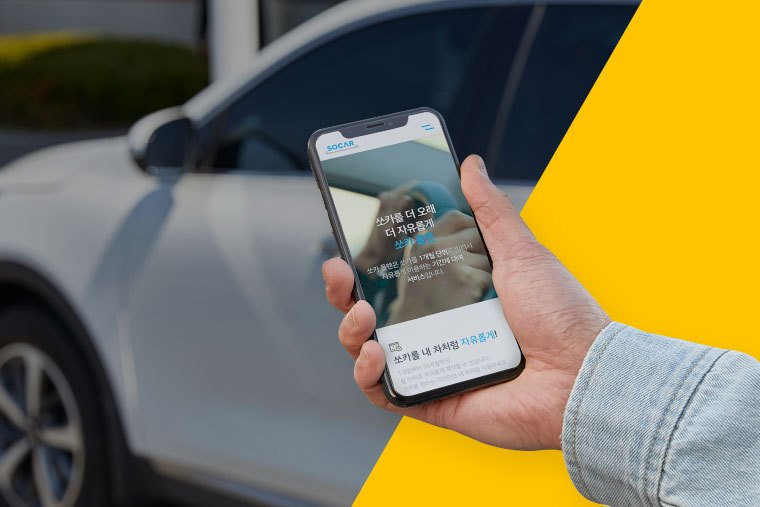

https://blog.socar.kr/10295

쏘카 또는 그 밖의 카셰어링 서비스를 이용한 경험이 있는 분들께서는 아시겠지만, 고객의 입장에서 매우 귀찮은 과정을 거치게 됩니다.

바로 차량을 이용하기 전과 후에 애플리케이션을 통해 자동차의 전면, 후면, 운전석 앞면 등의 외관을 촬영하는 과정입니다.

이 과정을 통해 매일 10만 장 이상의 사진이 업로드되고 있습니다. 어마어마한 양이죠?

쏘카에서는 업로드 된 챠랑 외관 사진을 확인하고, 이상이 발견되면 이상 부위를 기록하여 공업사(정비소)에 입고 시켜 차를 수리합니다.

하지만 귀찮은 과정이기 때문일까요? 업로드된 사진을 확인해보면 촬영 가이드가 존재하지만 정말 천차만별로 차량 외관이 촬영되어 있습니다. `차량 전면`을 촬영해야 하는 부분에서 `후면`을 촬영하거나, `확대하여 촬영`하는 등 의도하지 않았던 사진들이 섞여 있거나 , `사진을 찍지 않고 넘어가는` 경우가 있습니다.

점점 많아지는 쏘카 서비스의 이용량과 함께 촬영된 사진은 그 양이 많아지고 있으며, 이에 따라 쏘카의 매니저가 모든 사진을 상세하게 확인하기 어렵게 되었습니다.

따라서 쏘카에서는 공업사(정비소)에 보낼 차량을 선발하여 수리를 진행하기 위해 자동차 외관 사진을 수집하고, 클러스터링(clustering) 기법을 활용하여 파손이 어떤 부위에 발생했는지 파악하여 검수의 일정 부분을 자동화하여 문제에 대응하고자 하는 노력을 하고 있습니다.

지금부터 쏘카의 상황을 조금 더 세부적으로 알아보고,

`Clustering`과 `Self-Supervised Learning`을 통해 문제를 해결하고 있는 과정을 함께 알아봅시다.

### 학습 목표

___

1.  쏘카 데이터베이스에 저장되는 자동차 사진의 부위 정보가 어떻게 활용되는지 알아본다.
    
2.  이미지의 Representation Vector를 추출하는 방법을 알아본다.
    
3.  Self supervised learning의 개념에 대해서 알아본다.
    

### 준비물

___

`cloud shell` 에서 아래 명령어를 입력하여 필요한 디렉터리를 생성, 데이터를 준비해 주세요

```
$ mkdir -p ~/aiffel/socar_clustering/data/images
$ unzip ~/data/avante_images.zip -d ~/aiffel/socar_clustering/data/images
```

또한 필요한 라이브러리를 import 해주세요.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import PIL.Image as Image
import shutil

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

device = 'cuda:0'

print("import 완료!")

## 7-2. 쏘카 유저들이 촬영한 자동차 외관 사진

스마트 카셰어링 서비스 `쏘카`를 이용해 보신 분들이라면 한번쯤 이용 전에 자동차의 외관 사진을 촬영해본 경험이 있을 것입니다.

쏘카 서비스 이용 고객들은 총 6개의 부위에 대해서 사진을 찍어 올리고 특별히 해당 부위내에 파손이 되어있는 부분이 있다면 해당 부분을 클로즈업 해서 사진을 촬영하게끔 안내 받습니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-09-28_11-32-30.png)

\[촬영 안내 부위: 전면, 보조석 앞면, 보조석 뒷면, 후면, 운전석 뒷면, 운전석 앞면\]

### 유저에게 보여지는 촬영 가이드

___

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/geurim1.max-800x600.jpg)

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/geurim2.max-800x600.jpg)

차량 외관 촬영은 다소 귀찮게 느껴질 수도 있는 절차지만 이용자분들에게 부탁을 드리는 이유가 있습니다!

-   차량 외관에 존재하는 파손에 대해 고객이 인지하고, 이전 사고에 대한 면책을 위함입니다.
-   운영 차원에서 고객 안전에 위해가 될 수 있는 요소들을 사전에 인지하기 하기 위함입니다.

### 자동차 사진의 부위 정보를 왜 알아야 할까요?

___

쏘카의 관점에서 **자동차 파손 부위**를 촬영하는 이유를 조금 더 깊게 생각해 보겠습니다.

**이유 1. 차량이 손상되면 공업사에 수리를 맡기고, 입고 시에 손상 부위 정보를 모두 체크해주어야 합니다.**

-   과거에는 담당 매니저가 직접 자동차의 외관 사진을 보고 손상 부위를 하나하나 표시해서 공업사에 넘겨주었지만, 이 방법은 효율적이지 않았습니다.
-   하루에 10만장 이상의 차량이 업로드되는 상황에서 현실적으로 담당 매니저가 모든 사진을 확인할 수도 없습니다.

**이유 2. 어떤 부위가 파손되었는지 정확하게 알 수 있습니다.**

-   쏘카에서는 [Semantic Segmentation을 기반으로 한 파손 영역 탐지 모델](https://tech.socarcorp.kr/data/2020/02/13/car-damage-segmentation-model.html)을 운영하고 있습니다.
-   파손 영역을 AI가 파악하고 있지만, 파손 부위가 어떤 부위인지는 Segmentation 모델이 알려주지는 못합니다.
-   따라서 파손 영역이 차량의 어떤 부위에 발생한 것인지 부위 정보를 알아야 합니다.

즉 매일 10만 장 이상 업로드되는 이미지를 사람이 모두 검수할 수는 없으니 일정 부분을 자동화해줄 수 있는 기능이 필요하다는 것입니다.

하지만 유저들이 정확하게 이 가이드를 따르지 않기 때문에 문제가 발생합니다.

`전면` 사진을 올리는 부분에 `보조석 앞면`을 올리는 경우도 있고, 차량의 전체적인 모습을 올리기도 합니다. 특정 부위만 클로즈업되어 촬영한 경우는 위의 6개의 범주만으로는 정확히 레이블링하기가 어렵습니다.

카메라의 사양, 촬영 환경, 각도 등에 따라서 이미지가 회전되어 DB에 저장되는 경우도 많습니다. 또한 촬영한 스마트폰 종류에 따라서 이미지 크기가 모두 다른 문제도 있습니다.

요약하면 아래와 같습니다.

> -   weakly-labeled(예를 들면 운전석 쪽 측면 범퍼 깨짐 사진이 '전면'으로 레이블링) or unlabeled 되어있다.
> -   이미지들의 사이즈가 모두 달라서 resizing이 필요하다.
> -   이미지들이 rotate 된 경우도 많다.

### 분석 대상 이미지 파악

___

이제 분석 대상 이미지들의 개수를 파악해보고 실제로 어떤 이미지들이 존재하는지 plot을 그려 알아보도록 합시다.

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/socar_clustering/data/images/avante_images'
print('분석 대상 이미지들의 개수: ', len(os.listdir(img_path)))

fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서

    filename = os.listdir(img_path)[i]
    filepath = os.path.join(img_path, filename) # 파일 이름으로 읽고
    img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)# 이미지를 plotting 합니다
plt.show()

여러 부위의 자동차 사진들이 존재함을 볼 수 있죠?

**이때 우리는 두 가지 내용을 파악할 수 있습니다.**

-   이미지들마다 크기가 모두 다르다.
-   이미지들마다 레이블링하기 애매한 부위들이 존재한다.

## 7-3. 문제 접근 전략 : 이미지 resizing

이번 스텝에서는 자동차 부위 사진을 어떻게 전처리하여 이용할지를 고민해 보는 시간을 가지도록 하겠습니다. 이미지의 형태와 채널 구조를 파악한 후 각각 다른 크기의 이미지를 알맞게 resizing하겠습니다.

### Channel 구조 파악하기

___

이미지 분석의 가장 첫 걸음은 이미지 채널 구조를 살펴보는 일입니다. 이미지를 읽고, 형태를 파악하여 채널 구조를 살펴봅시다! 채널 구조를 파악하는 단계는 아래와 같습니다.

> -   OpenCV-python으로 이미지 읽기
> -   이미지 NumPy array 형태에서 channel 파악하기
> -   BGR 채널 → RGB 채널로 바꾸어주기

In [ ]:
sample_path = os.getenv('HOME')+'/aiffel/socar_clustering/data/images/avante_images/0.jpg' # path를 정의하고
sample_img = cv2.imread(sample_path) #  OpenCV-python을 이용해서 이미지를 읽기

print(type(sample_img)) # NumPy.array 타입
print(sample_img.shape) # height 1633 x width 1080 x channel 3 짜리 이미지가 나왔습니다

`opencv`을 이용해서 이미지를 읽어보면, `numpy.array type`의 무언가를 return 해주는 것을 확인할 수 있습니다. 이미지를 다룰 때 생각해야 할 기본은

-   이미지는 숫자들이 모인 array들의 모임이며,
-   여러 개의 채널이 겹쳐져있는 array (주로 RGB 3개의 채널이 존재)

라는 것을 염두에 두어 주세요!

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/image_channel.max-800x600.png)

그러면 각 채널의 이미지가 어떻게 생겨져있는지 알아볼까요?

In [ ]:
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(sample_img)

plt.subplot(1,2,2)
plt.title('Channel 0')
channel_img = sample_img[:,:,0] # 0번째 채널 이미지
plt.imshow(channel_img)

channel을 하나만 골라서 이미지를 시각화해보면, 위 처럼 이미지의 색상 정보가 상당히 손실된 것을 알 수 있습니다.

왼쪽의 Original 이미지를 잘 살펴보면, 이미지가 약간 푸르스름한 느낌이 들지 않나요? 그 이유는 OpenCV-python으로 이미지를 읽으면 채널이 RGB가 아닌 BGR로 읽혀지기 때문입니다. 이 이미지를 다시 RGB 채널로 뒤집어주어야 합니다!

In [ ]:
sample_img_rgb = sample_img[:,:,::-1]
plt.imshow(sample_img_rgb)

### 이미지 Resizing 전략 세워보기

___

이전 스텝에서 살펴본 이미지들에서는 각 이미지들의 크기가 모두 다른 문제가 있었습니다. CNN에는 동일한 크기의 이미지를 넣어주어야 하므로, 서로 다른 이미지들을 동일한 크기로 Resizing해주어야 합니다. 이 때 어떤 Resizing 전략을 선택하는 것이 차량 이미지의 특징을 최대한 손실없이 보존하면서 크기를 통일시켜줄 수 있을까요?

`TORCHVISION.TRANSFORMS`에 어떤 resizing 방법들이 있는지 한 번 확인해 봅시다.

-   [TORCHVISION.TRANSFORMS Reference](https://pytorch.org/vision/stable/transforms.html)

Q1. 다음 중 자동차 외부 사진의 특징을 최대한 보존할 수 있는 Resizing 방법은 무엇인가요?

-   CenterCrop
-   Random Resize Crop
-   Resize (Linear Interpolation)

예시답안  
Resize 입니다!

샘플 이미지를 하나 고르고, 각 Resizing 방법에 따라서 이미지가 어떻게 달라지는지 알아봅시다!

이미지 데이터 타입으로 OpenCV는 NumPy의 ndarray를 사용하고, torchvision은 Python Image Library(PIL)의 Image를 사용합니다. 따라서, torchvision의 기능을 사용하기 위해서는 다루는 이미지의 데이터 타입을 NumPy의 ndarray에서 PIL의 Image로 변환해주는 과정이 필요합니다. 먼저 샘플 이미지 하나를 고르겠습니다.

In [ ]:
from PIL import Image

img = Image.fromarray(np.uint8(sample_img_rgb))
plt.imshow(img)

위에서 살펴보았던 각각의 Resizing 방법, 즉 `CenterCrop`, `Linear Interpolation`, `RandomCrop`을 사용하면 샘플 이미지가 어떻게 달라지는지 알아봅시다.

In [ ]:
from torchvision import datasets, transforms

center_cropper = transforms.Compose([
    transforms.CenterCrop((224,224)),
])

interpolater = transforms.Compose([
    transforms.Resize((224,224), interpolation=Image.NEAREST)
])

random_cropper = transforms.Compose([
    transforms.RandomCrop((224,224))
])

center_crop = center_cropper(img)
interpolate = interpolater(img)
random_crop = random_cropper(img)

plt.figure(figsize=(13,5))
plt.subplot(1,4,1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1,4,2)
plt.title('Center Crop')
plt.imshow(center_crop)

plt.subplot(1,4,3)
plt.title('Interpolate')
plt.imshow(interpolate)

plt.subplot(1,4,4)
plt.title('Random Crop')
plt.imshow(random_crop)

잘 확인되시나요? `Centercrop`은 이미지의 중간 부분만 나왔고, `RandomCrop`는 랜덤하게 특정 부분만 추출되었습니다. 보시는 것처럼 보간을 이용하여 Resizing한 것이 이미지 원본을 가장 잘 보존할 수 있습니다.

## 7-4. 문제 접근 전략 : 분류? 클러스터링?

### 문제 접근 방식 결정하기 (Labeling Scheme 세워보기)

___

우리의 목적은 자동차 외관 사진이 어떤 부위인지 구분하는 것입니다. 같은 크기로 resizing한 이미지를 **어떤 모델** 의 입력으로 주어 **원하는 결과** 를 얻어낼 것인가를 고민해야 합니다.

이 목적을 달성하기 위해서 2가지 접근 방식을 세워 볼 수 있습니다. 바로 Classification 문제로 접근할 것이냐, Clustering 문제로 접근할 것이냐입니다.

Classification을 먼저 생각해보면, 일단 우리가 가지고 있는 이미지들을 명확하게 구분할 수 있는 Labeling Scheme을 세울 수 있는지를 먼저 검토해보아야 합니다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcnvUdJ%2Fbtrc3pAHvuL%2FnODaHzvjz5Dkc23wyvw2y0%2Fimg.png)

샘플로 몇 장의 이미지를 가져와 보았는데요, 세 이미지 모두 "문"이 포함되어 있습니다.

이 경우, 각 3장의 이미지는 동일한 Class로 분류되어야할까요? 아니면 모두 다른 Class로 분류되어야 할까요?

이때 던져볼 수 있는 질문은 "10명의 사람에게 위 이미지들을 레이블링하라고 말하면 모두 동일하게 구분할까?"입니다. 아마 10명은 레이블링 결과를 모두 다르게 낼 것입니다.

이처럼 각 Class들 사이에 명확한 구분기준을 세우기가 어려운 경우에는 직접 Labeling하거나 Labeler를 고용해서 Labeling하기가 매우 어렵습니다.

따라서 Classification으로 문제를 풀기보다는 Clustering 방법으로 접근하는 것이 더 합리적이라고 생각해볼 수 있습니다.

Clustering(클러스터링)이란 무엇일까요?

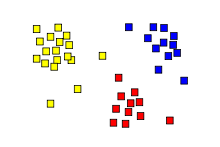

[clustering 예시]

https://en.wikipedia.org/wiki/Cluster_analysis

클러스터링은 머신러닝 중 비지도 학습 방법의 하나로서, 샘플의 특징을 이용하여 비슷한 것끼리 그룹화하는 방법입니다.

구글 개발자 페이지의 클러스터링에 대한 설명을 읽어보고 퀴즈를 풀어보도록 합시다.

[구글 개발자 페이지 - 클러스터링](https://developers.google.com/machine-learning/clustering/overview)

Q2. 클러스터링이 사용되는 산업 분야에는 어떤 것들이 있나요?

예시답안

market segmentation

social network analysis

search result grouping

medical imaging

image segmentation

anomaly detection

### 평가 방식 결정하기

___

> ❓ Classification 문제를 풀 때는 Accuracy, Precision, Recall, F1 Score를 최대로 끌어올리는 것이 목표입니다. 그렇다면 Clustering Task에서는 어떻게 모델이 잘 clustering 했는지 알 수 있을까요?

클러스터링은 비지도 학습이기 때문에 공인된(globally accepted)된 평가척도는 없습니다. 따라서 클러스터링을 통해 정확한 정답을 찾아낼 수는 없습니다.

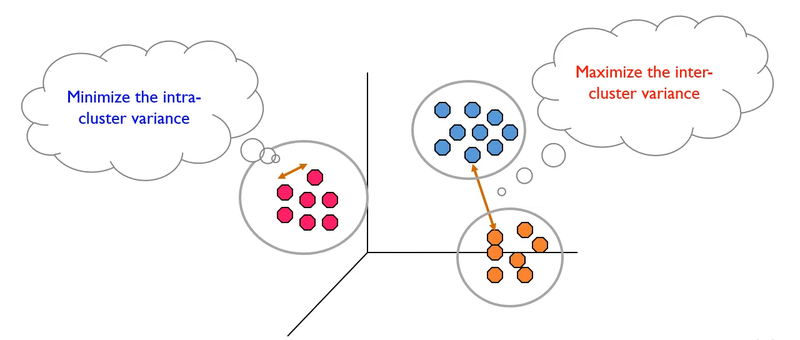

[clustering 평가 기준]

https://github.com/pilsung-kang/Business-Analytics-ITS504-/blob/master/07%20Clustering/07-1_Clustering_Overview.pdf


그러나 위의 그림에서 볼 수 있듯이 `군집내 분산은 최소화`, `군집간 분산은 최대화`한다는 원칙을 따른 `군집의 타당성 지표`들이 있습니다. 이 지표에 따른 클러스터링 평가척도의 예는 아래와 같습니다.

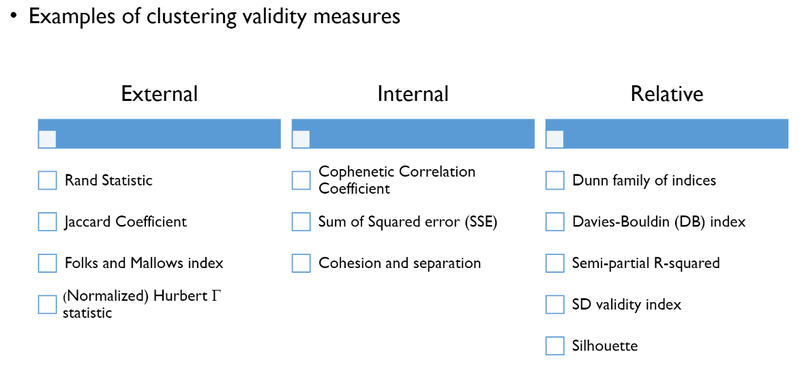

[클러스터링 평가척도]

https://github.com/pilsung-kang/Business-Analytics-ITS504-/blob/master/07%20Clustering/07-1_Clustering_Overview.pdf

globally accepted한 평가척도가 없기 때문에, 특정 Cluster에 비슷한 이미지들끼리 잘 묶여있는지 여부를 Qualitative(정성적)하게 판단하여 성능을 평가하는 것이 좋은 방법일 수도 있습니다. `cluster별 이미지를 ploting`해서 확인해 보면 되겠죠.

클러스터링에 관한 자세한 내용은 아래의 자료를 참고하세요.

-   [고려대학교 강필성 교수 강의](https://youtu.be/X6kCkqQPRvE)
    
-   [고려대학교 강필성 교수 강의자료](https://github.com/pilsung-kang/Business-Analytics-ITS504-/blob/master/07%20Clustering/07-1_Clustering_Overview.pdf)

## 7-5. 이미지를 벡터로 바꿔주기(Representation Vector)

이미지 클러스터링을 위해서는 고차원 이미지 데이터를 저차원으로 매핑해야 합니다. 이후 CNN 아키텍처(Architecture)를 이용하여 Representation Vector를 뽑는 과정을 거칩니다.  
해당 과정을 자세하게 살펴보겠습니다.

### Representation Vector

___

이미지는 width, height, channel의 3차원 벡터로 이루어져 있습니다. 해당 벡터에 바로 클러스터링 기법을 적용해 볼 수도 있지만, 아무런 처리를 하지 않은 상태에서는 좋은 성능을 낼 수 없습니다. 이미지 자체는 고차원 데이터(high-dimensional)이기 때문에, 클러스터링 알고리즘을 바로 적용하면 [차원의 저주](http://www.aitimes.com/news/articleView.html?idxno=138584)에 빠지게 되는 것이죠.

따라서 클러스터링을 잘하기 위해서는 해당 이미지의 특징은 잘 유지하면서 저차원(low-dimensional)의 공간으로 매핑시키는 작업이 필요합니다. PCA와 같은 알고리즘을 이용할 수도 있겠지만, 이미지의 특징을 제대로 담고 있지 못할 가능성이 큽니다. 그러므로 뛰어난 성능을 위해 딥러닝 네트워크를 이용해서 이미지의 특징을 추출해 보려고 합니다.

딥러닝을 공부하는 동안 컴퓨터 비전 분야의 백본 네트워크, AlexNet, VGG, ResNet 등을 들어보셨을 것입니다. 이것들은 이미지 인식에 뛰어난 성능을 보이는 모델입니다. 해당 모델의 구조를 이용하면 이미지 정보를 잘 담고 있는 벡터를 추출할 수 있습니다.

이를 `Representation Vector` 라고 하는데요, "표현 벡터"라고 번역할 수 있습니다. 데이터(이미지)를 잘 표현하고 있는 벡터라고 할 수 있습니다.

> 정리
> 
> -   이미지 클러스터링을 위해선 고차원 이미지 데이터를 저차원으로 매핑해야한다.
> -   CNN 아키텍처를 이용하여 Representation Vector를 뽑는다.

그렇다면 아래와 같은 CNN 아키텍처의 어느 부분에서 Representation Vector를 뽑아볼 수 있을까요?

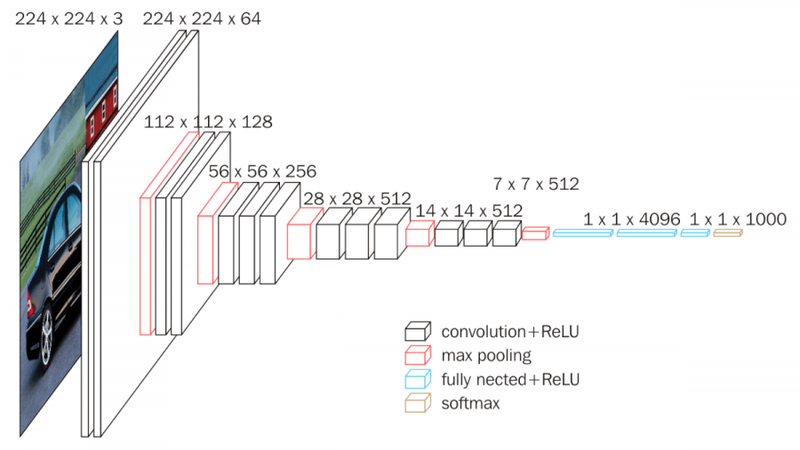

[VGG16 구조]

https://neurohive.io/en/popular-networks/vgg16/

주로 pooling layer에서 나온 벡터를 사용합니다. 따라서 pooling layer까지를 feature extracter(특징 추출기)라고 하며 그 이후는 classifier(분류기)라고 합니다.

아래 그림에서 보라색 네모 박스친 부분이 pooling layer로, 7x7x512 크기의 Representation Vector를 뽑아내고 있는 것을 알 수 있습니다.

물론 다른 층에서 뽑아내도 문제가 없습니다. 어느 방법이 좋을지는 해봐야 압니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/Frame_1_yW9YBjN.max-800x600.png)

아래 링크에서 특징 추출기와 분류기가 어떤 의미를 가지고 있는지 한 번 확인 해 봅시다.

-   [Why we include_top=False while using pretrained models like InceptionResnetV2 in keras?][1]

[1]: https://stackoverflow.com/questions/54059391/why-we-include-top-false-while-using-pretrained-models-like-inceptionresnetv2-in

## 7-6. Self-Supervised Learning이란?

Tensorflow에서 대부분의 백본 네트워크는 ImageNet에서 사전 학습한 weight를 제공합니다. 이전 스텝에서 보여드렸던 VGG-16 구조를 이용하여 ImageNet에서 학습한 weight를 불러와 자동차 외관 이미지의 특징을 추출한다면 어떻게 될까요?

이렇게 추출한 Representation vector로는 어느 정도는 클러스터링이 되지만 좋은 결과를 얻기는 힘듭니다. 왜냐하면 ImageNet은 다양한 사물 이미지를 포함하고 있기 때문입니다. 자동차 외관 이미지에 맞춰진 모델은 아니라는 것이죠.

그렇다면 좋은 Representation Vector를 얻기 위해선 어떻게 해야 할까요? 자동차 외관 이미지에 맞춰서 모델을 학습하면 되겠죠? 즉 VGG-16의 weight가 자동차 외관 이미지의 특징을 잘 이해할 수 있도록 해야 합니다.

하지만 우리는 지금 자동차 외관 이미지의 Label을 가지고 있지 않습니다. 그러므로 클러스터링 기법을 이용하려고 한 것입니다.

그렇다면 이제 어떻게 해야 할까요?, 답은 Self-Supervised Learning에 있습니다!

### Self-Supervised Learning 공부하기

___

이때 우리가 사용할 수 있는 기법이 바로 Self-Supervised Learning입니다. Self-Supervised Learning이 무엇인지 아래 영상을 보고 한번 공부해볼까요?

-   [DMQA Open SeminarSelf Supervised Learning](https://www.youtube.com/watch?v=5BCQ7T2Rw1w) (총 36:51)
    
-   [PR-208: Unsupervised Visual Representation Learning Overview:Toward Self-Supervision](https://www.youtube.com/watch?v=eDDHsbMgOJQ&t=1s) (총 23:34)
    

Q3. Self-Supervised Learning이란 무엇인가요?

예시답안

주어진 데이터부터 self로 supervision을 주는 것.

unlabled 데이터만을 이용해서 학습을 한다.

유저가 창작해낸 문제들(pretext task)을 이용하여 이미지의 sementic한 정보들을 학습할 수 있도록 한다.

정리해보면, Self-Supervised Learning에는 크게 2가지 Category가 있습니다

> -   Pretext Learning (rotation prediction, Jigsaw Puzzle, Colorization 등)
> -   Contrastive Learning (SimCLR, MoCo 등)

여러 논문들을 살펴보면, `Contrastive Learning`의 학습을 위해서는 매우 많은 데이터와 수많은 연산량이 필요하다고 알려져 있습니다.

우리는 편리한 구현과 적은 리소스만으로도 우리 데이터를 잘 이해하는 weight를 만들 수 있는 `Pretext Learning` 방법을 구현해 볼 것입니다.

### Rotation Prediction

___

Rotation Prediction은 Self-Supervised Learing의 Pretext Learning 기법 중 하나입니다. 이 방법은 한 이미지를 각각 0, 90,180,270도 회전시켜서 이미지가 몇 도 회전되었는지 분류하도록 학습합니다.

이미지가 몇 도 회전되었는지를 예측하려면 모델이 이미지의 `canonical orientations` 을 잘 학습되게끔 해야 하는데 이렇게 하다 보면 이미지의 전반적인 특징을 잘 학습할 수 있게 됩니다.

> ➰ canonical orientations 이란?  
> 'canonical'은 규정, 표준형이라는 뜻을 가지고 있습니다. 따라서 canonical orientations이란 일반적인 방향, 표준적인 방향이라고 해석할 수 있을 거에요. 아래의 그림에서 Image X가 canonical orientation을 나타내는 이미지입니다.

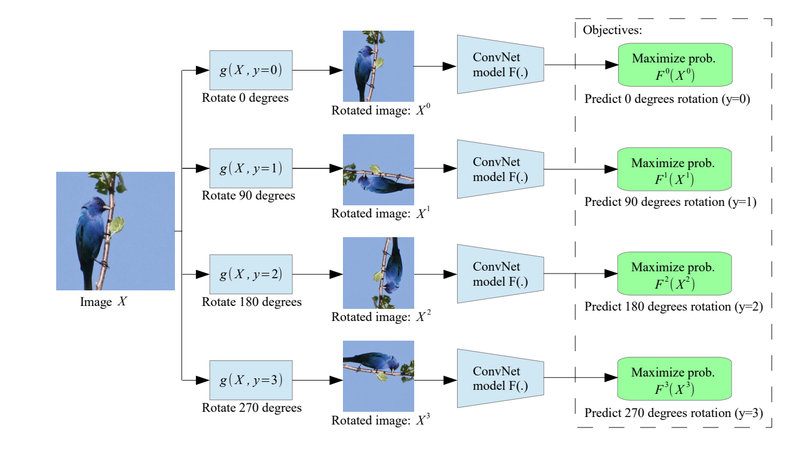

https://arxiv.org/pdf/1803.07728.pdf

Rotation Prediction 기반의 Self Supervised Learning 기법은 아래 논문에 소개되어 있습니다.

앞서 시청한 2개 영상보다 더 자세한 설명을 보고 싶으시다면, 아래 논문을 읽어보시는 것을 추천합니다.

-   Unsupervised Representation Learning by Predicting Image Rotations 2018 ICLR

https://arxiv.org/pdf/1803.07728.pdf

Q4. Rotation Prediction 기법이란 무엇인가요?

예시답안

image의 rotation을 학습하도록 하는 pretext task이다.

single 이미지를 0,90,180,270, random하게 rotation했을때 해당 이미지가 원본으로부터 몇 도 rotation되었는지를 분류기가 학습하도록 모델을 학습시킨다.

## 7-7. 마무리하며

지금까지 아래의 3가지 학습목표를 달성하기 위해 학습을 진행했습니다.

1.  쏘카 데이터베이스에 저장되는 자동차 사진의 부위 정보가 어떻게 활용되는지 알아본다.
    
2.  이미지의 Representation Vector를 추출하는 방법을 알아본다.
    
3.  Self-Supervised Learning의 개념에 대해서 알아본다.
    

자동차 사진의 부위 정보는 2가지 부분에서 사용이 되고 있었습니다. 첫번째는 차량이 손상되었을 때 공업사에 수리를 맡기며 부위 정보를 체크해 주어야 할 때였고, 두번째는 파손이 어떤 부위에 발생한 것인지 부위 정보를 알아야 때였습니다.

쏘카 유저들에게 `전면, 운전석 앞면, 보조석 앞면, 후면, 운전석 뒷면, 보조석 뒷면`의 총 6개 부위에 대한 촬영 요청이 가긴 하지만, 유저들이 이를 완벽히 따르지 않기도 하고 6개 부위에 해당한다고 보기 어려운 부위(바퀴 부분, 문 부분 등)들도 존재했습니다.

그래서 우리는 자동차 외관 사진이 어떤 부위인지 구분하기 위해서 classification 과 clustering 중 어떤 방법을 이용해야 할까 고민했습니다. 이미지의 특성을 살펴보니 class들 사이의 명확한 구분 기준을 세우기 어려웠기 때문에 labeler를 고용해서 레이블링을 수행하기도 어려웠기 때문에 clustering을 이용하기로 결정했습니다.

이미지 클러스터링을 위해서는 이미지로부터 `Representation Vector`를 뽑아내야 했습니다. 좋은 Representation Vector를 뽑아내기 위해 컴퓨터 비전 분야에서 발전해 온 `백본 네트워크` 이용했습니다. 백본 네트워크는 이미지에서 특징을 추출해 내는 `특징 추출기`와 클래스를 분류해 내는 `분류기`로 나누어졌고, 우리는 특징 추출기 부분을 이용해서 벡터를 추출해 냈습니다.

대부분의 백본 네트워크에서 ImageNet으로 사전 학습된 weight를 제공합니다. 이 가중치를 이용해도 어느 정도의 성능이 나오긴 하지만, 더 좋은 벡터를 추출해 내기 위해서 self-supervised learning을 이용하기로 했습니다. 자동차 외관 사진 이미지를 가지고 pretext task를 정의하여 이 문제를 잘 풀어내는 모델을 학습시키는 것이죠. 여러 가지 pretext task가 있지만 우리는 간단하지만 성능이 뛰어난 rotation task에 초점을 맞춰 학습을 하였습니다.

여기까지 정리가 잘 되셨나요? 아직 완벽히 이해가 되시진 않았을 수 있습니다. 하지만 걱정하지 마세요! `learning by doing` 아시죠? 다음 노드에서 이 내용에 대해 코드와 함께 실습을 진행하고, 직접 쏘카 데이터를 이용해 구현하는 프로젝트를 진행해 볼 계획입니다.

다음 시간에 만나요!😀

In [1]:
pip list

Package                       Version
----------------------------- ------------------
absl-py                       0.12.0
aiohttp                       3.8.1
aiosignal                     1.2.0
albumentations                1.1.0
antlr4-python3-runtime        4.8
anyio                         3.4.0
appdirs                       1.4.4
argon2-cffi                   21.1.0
astunparse                    1.6.3
async-generator               1.10
async-timeout                 4.0.1
attrs                         21.2.0
audioread                     2.1.9
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.6.0
black                         21.12b0
bleach                        4.1.0
branca                        0.4.2
brotlipy                      0.7.0
cachetools                    4.2.4
certifi                       2021.10.8
cffi                          1.15.0
chardet                       3.0.4
charset-normalizer            2.0.8
clang 

Note: you may need to restart the kernel to use updated packages.
